In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob

## Import Data

In [2]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("../data/labeled_data/lagged_labeled_data.csv")
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())
# print(labeled_index)

#Features Columns
features_columns = list(labeled_index.columns)
columns_to_remove = ['index', 'crash_label', 'date', 'Quarter']
features_columns = [column for column in features_columns if column not in columns_to_remove]
# print(features_columns)

In [8]:
# Selected by eliminating 30% 0f features with lowest abs importance_coed in log regression 
features_columns =['000001.SS', '^BSESN', '^BVSP', '^FCHI', '^FTLC', '^GDAXI', '^GSPC', '^HSI', '^N225', '^SSMI',
 'current_acct_lag2', 'npl_lag2', 'npl_lag1', 'Population_lag2',
       'Recession_Indicators_lag1', 'Population_lag1', 'volatility_lag1',
       'volatility_lag2', 'current_acct_lag1', 'turnover_lag1',
       'volume_change_lag2', 'Recession_Indicators_lag2', 'turnover_lag2',
       'Unemployment_lag2', '10YGov_BondYield_lag2',
       '10YGov_BondYield_lag1', 'Unemployment_lag1', 'Ted_Rate_lag1',
       'GDP_lag2', 'inflation_lag2', 'GDP_lag1',
       'Crude_Oil_Index_Excess_Return_lag2',
       'Crude_Oil_Index_Excess_Return_lag1', 'housing_lag2',
       'price_change_lag1', 'inflation_lag1']

# Build the model

In [9]:
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
shap_values_list = []
best_params_list = []

for train_index, val_test_index in tscv.split(quarters):
    val_index = val_test_index[:int(len(val_test_index) * 0.5)]
    test_index = val_test_index[int(len(val_test_index) * 0.5):]
    train_quarters, val_quarters, test_quarters = quarters[train_index], quarters[val_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    val = labeled_index.loc[val_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_val = val[features_columns]
    y_val = val['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning with val
    scale_pos_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)
    
    if not all(label == 0 for label in y_val):
        param_grid = {'max_depth':[4,6], 
            'n_estimators':[150,250], 
            'learning_rate':[0.15,0.1],
            'scale_pos_weight':[scale_pos_weight], 
            'subsample': [0.6],
            'gamma': [0.05,0.1],
            'colsample_bytree': [0.6],
            'min_child_weight': [1.5,2],
            # 'reg_alpha': [0.5],
            'reg_lambda': [1.0,1.5]}
        grid_search = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic'), param_grid, cv=tscv, scoring='f1', verbose=3)
        grid_search.fit(X_val, y_val)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_params_list.append(best_params)
        print(f"Best Score: {best_score}")
        print(f"Best Param: {best_params}")
        print("Grid search completed successfully.")
    else:
        best_params = best_params_list[-1]

    # Train the model
    model = xgb.XGBClassifier(objective='binary:logistic',
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        scale_pos_weight=scale_pos_weight,
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        gamma=best_params['gamma'],
        min_child_weight=best_params['min_child_weight'],
        reg_lambda=best_params['reg_lambda']
        # scale_pos_weight=best_params['scale_pos_weight']
    )
    model.fit(X_train_resampled, y_train_resampled)
    
    # Save the trained model to a file
    # joblib.dump(model, 'logistic_regression_model.joblib')
    print("prediction model trained")
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict decision values on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X_test)
    shap_values_list.append(shap_values)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Val_Start': pd.to_datetime(val_quarters).min(),
        'Val_End': pd.to_datetime(val_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Calculate feature importance
    feature_names = list(X_train.columns)
    feature_importance = model.feature_importances_
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.400 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.333 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0

[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.333 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_

[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.333 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambd

[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.400 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambd

[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.400 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambd

[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.400 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambd

[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.5

[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.400 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, 

[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.5, scale_pos_weight=4.517241379310345, subsample=0.6;, score=0.000 total time=   0.1s
Best Score: 0.16
Best Param: {'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.15, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 150, 'reg_lambda': 1.5, 'scale_pos_weight': 4.517241379310345, 'subsample': 0.6}
Grid search completed successfully.
prediction model trained
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.

[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.5

[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.5

[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.2s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.5, sca

[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.2s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.5, sca

[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.0, sca

[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.0, sca

[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_po

[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=250, reg_lambda=1.0, scale_po

[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.5

[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.5

[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.5, sca

[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.5, sca

[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.5, sca

[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.5, sca

[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_po

[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6;, score=0.000 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=150, reg_lambda=1.5, scale_po

In [10]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_XGBoost_features.csv", index=False)
evaluation_df
#TODO: visualize it

,Train_Start,Train_End,Val_Start,Val_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,...,Unemployment_lag1_importance,Ted_Rate_lag1_importance,GDP_lag2_importance,inflation_lag2_importance,GDP_lag1_importance,Crude_Oil_Index_Excess_Return_lag2_importance,Crude_Oil_Index_Excess_Return_lag1_importance,housing_lag2_importance,price_change_lag1_importance,inflation_lag1_importance
0,1998-09-30,2002-06-30,2002-09-30,2004-03-31,2004-06-30,2005-12-31,"[[56, 12], [2, 0]]",0.000000,0.000000,0.000000,...,0.008862,0.039587,0.029621,0.013101,0.041092,0.038791,0.035489,0.044692,0.020936,0.014634
1,1998-09-30,2005-12-31,2006-03-31,2007-09-30,2007-12-31,2009-06-30,"[[40, 2], [25, 3]]",0.600000,0.107143,0.181818,...,0.011520,0.039366,0.021965,0.011766,0.065702,0.028299,0.033451,0.028445,0.020445,0.015800
2,1998-09-30,2009-06-30,2009-09-30,2011-03-31,2011-06-30,2012-12-31,"[[55, 9], [5, 1]]",0.100000,0.166667,0.125000,...,0.010993,0.045657,0.009775,0.014954,0.033239,0.026990,0.020577,0.029330,0.032508,0.016601
3,1998-09-30,2012-12-31,2013-03-31,2014-09-30,2014-12-31,2016-06-30,"[[46, 13], [7, 4]]",0.235294,0.363636,0.285714,...,0.015783,0.028159,0.012062,0.013288,0.025766,0.023492,0.020277,0.036574,0.020043,0.014800
4,1998-09-30,2016-06-30,2016-09-30,2018-03-31,2018-06-30,2019-12-31,"[[53, 16], [1, 0]]",0.000000,0.000000,0.000000,...,0.014535,0.030429,0.024158,0.016666,0.025347,0.029052,0.021165,0.026153,0.026669,0.013413


## Shap Values

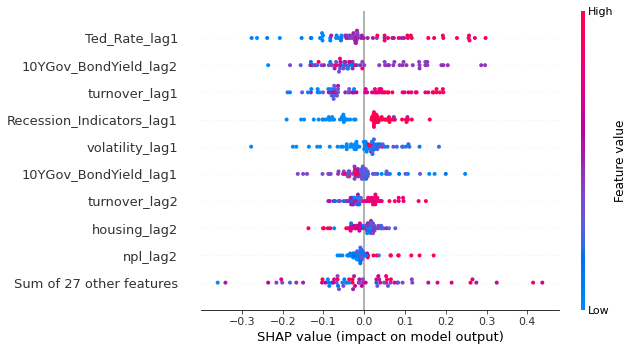

In [11]:
shap.plots.beeswarm(shap_values_list[4])

# Feature Importance

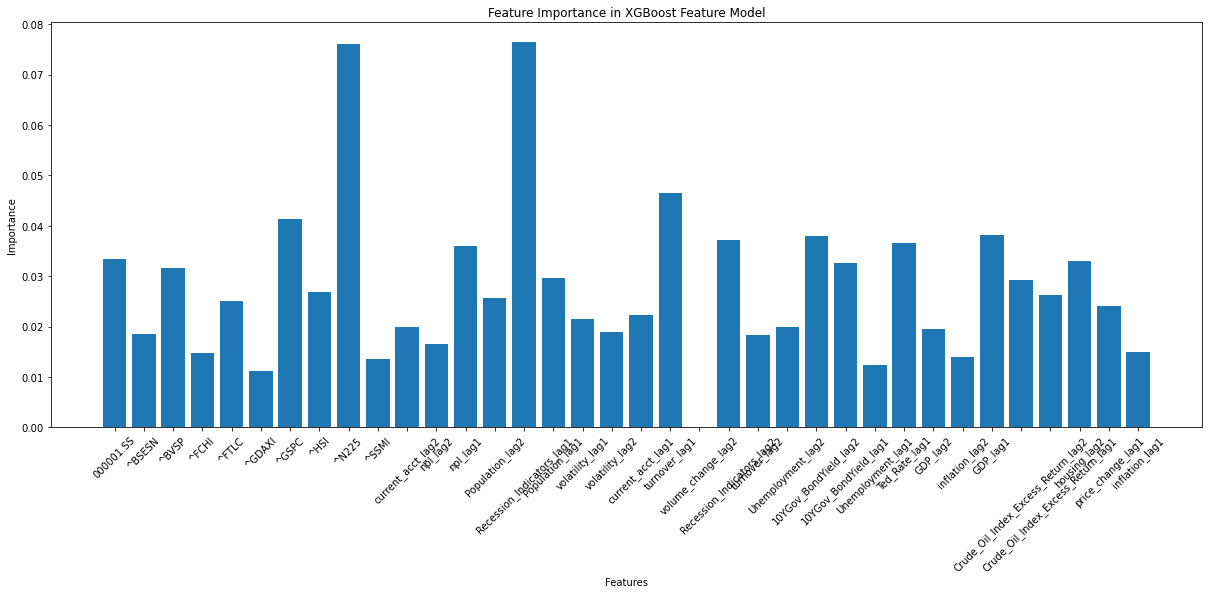

In [12]:
model_name = "XGBoost Feature"
plot_feature_importances(evaluation_df, model_name)

# AUC-ROC

In [13]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.642120643728785


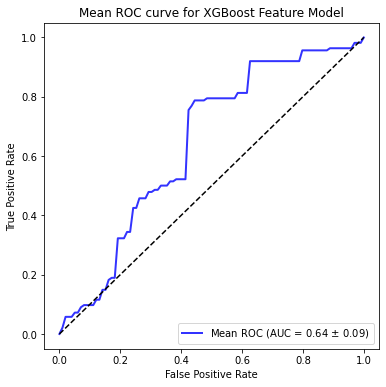

In [14]:
plot_roc_curve(evaluation_df, model_name)

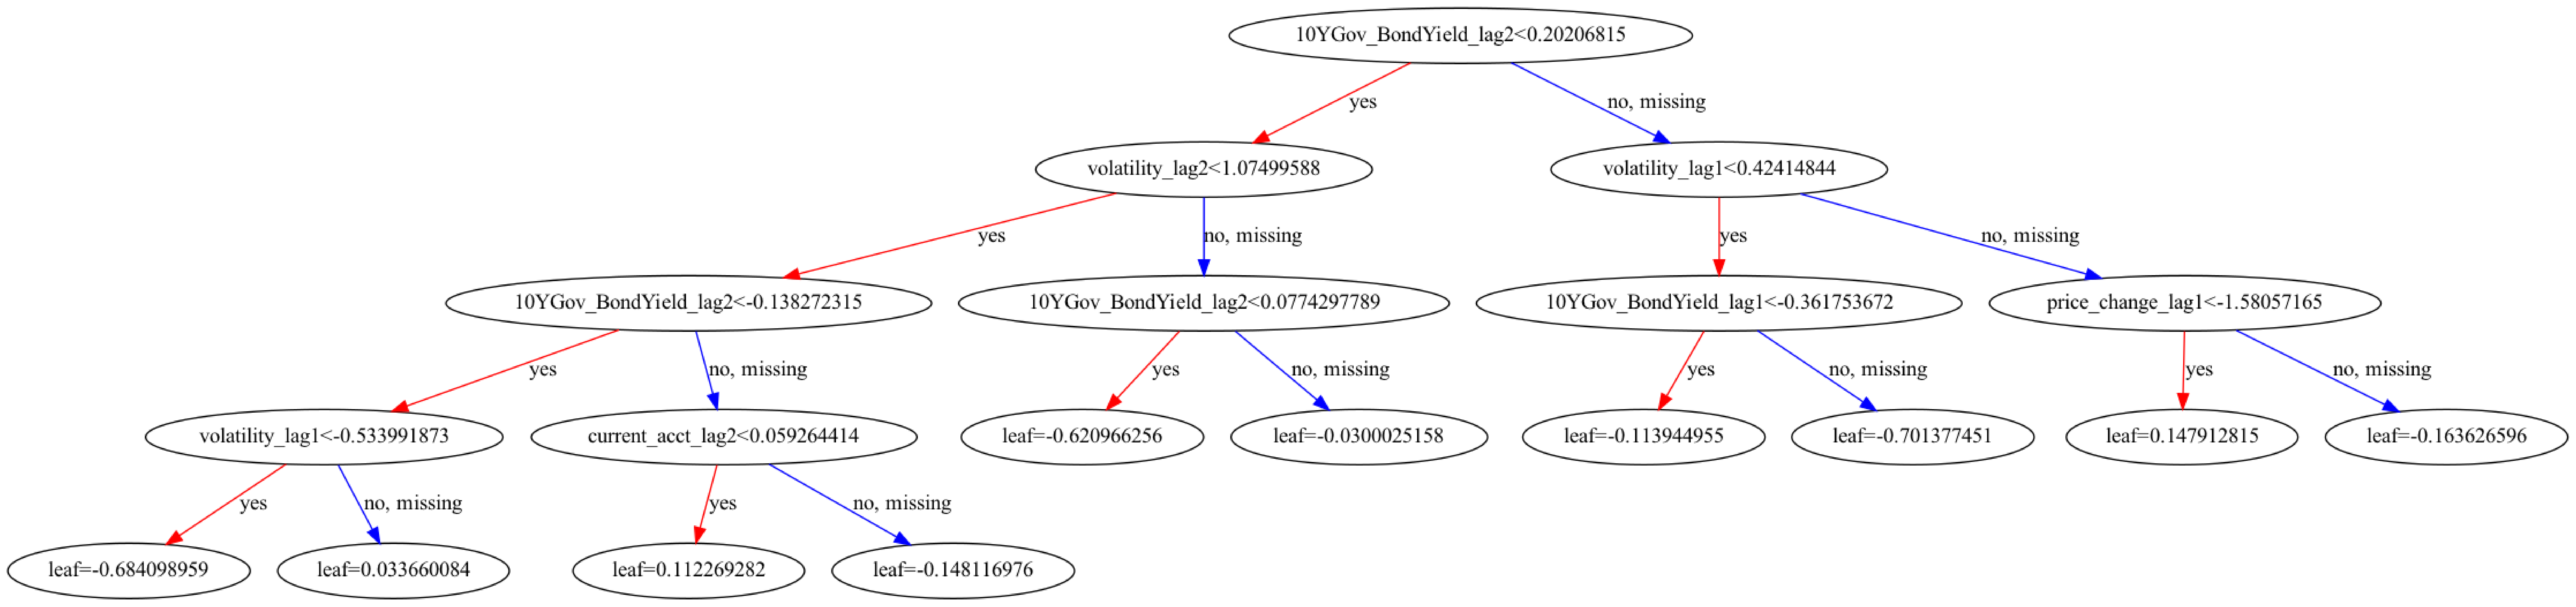

In [15]:
# pip install graphviz
fig, ax = plt.subplots(figsize=(170, 170))
xgb.plot_tree(model, ax=ax)
plt.show()